# $\tau$-Scaling for PIGS Simulations

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from graphenetools import gt
import re,glob,os
from scipy.signal import argrelextrema
from scipy.optimize import brentq
import multiprocessing 
import sys,importlib
from dgutils import colors as colortools
from collections import defaultdict
import pickle
from numpy import pi as π

# Notebook display options
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# plot style
plot_style = {'notebook':'../include/notebook.mplstyle','aps':'../include/aps.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['aps'])
figsize = plt.rcParams['figure.figsize']
plt.rcParams['text.latex.preamble'] = f'\input{{{os.getcwd()}/../include/texheader}}'

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Do you want to process the full data set?

Default is False. The full data set can be found here: 

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.4553524.svg)](https://doi.org/10.5281/zenodo.4553524)

A minimal set of reduced (averaged and processed) data files is included with the repository `../data/QMC.tar.bz2`.  We can extract if it hasn't already happened.

In [3]:
reduce_data = False
if not os.path.isdir('../data/QMC/'):
    ! tar xjf ../data/QMC.tar.bz2

## Some helper and analysis functions

In [4]:
import layerutils
from layerutils import lab,vals,texformat,get_base_dir
from pimcscripts import pimchelp

# get the graphene lattice information
Am, An, b1, b2, gm, gn = gt.get_graphene_vectors(0.0)

## Setting up and Extracting Information from the QMC Data

In [5]:
num_sites = [4]
filling = [1]
sim_params = {'T':0,'canonical':True,'n':0.038,'pimcid':'*tau|*77b'}

pimcid = defaultdict(dict)
par_map = defaultdict(dict)
base_dir = defaultdict(dict)
L,n,N,τ = defaultdict(dict),defaultdict(dict),defaultdict(dict),defaultdict(dict)
N_ads = defaultdict(dict)
simulations,pimcids = {},{}

for cnum in num_sites:
    Nkey = lab(N=cnum)
        
    # we consider unit filling here
    log_names = pimchelp.get_file_list_from_params(**sim_params, N=cnum,
                                                       base_dir=get_base_dir(cnum,sim_params['T']))   

    # We go through each file and automatically populate the simulation map
    for log in log_names:
        par_ = pimchelp.get_parameter_map(get_base_dir(cnum,sim_params['T']) + log)

        cN = par_['Initial Number Particles']
        cf = cN/cnum
        β = par_['Imaginary Time Length']

        sim = lab(T=sim_params['T'],n=cf,Lz=par_['Container Length'],N=cnum,β=β)
        pimcid[Nkey][sim] = par_['PIMCID']
        par_map[Nkey][sim] = par_
        base_dir[Nkey][sim] = get_base_dir(cnum,sim_params['T'])

        # We add some short-hand variables for ease of referencing
        L[Nkey][sim] = par_map[Nkey][sim]['Container Dimensions']
        n[Nkey][sim] = par_map[Nkey][sim]['Initial Density']
        N[Nkey][sim] = par_map[Nkey][sim]['Initial Number Particles']
        τ[Nkey][sim] = par_map[Nkey][sim]['Imaginary Time Step']
        N_ads[Nkey][sim] = [int(round(0.5*L[Nkey][sim][0]/An[0])),int(round(L[Nkey][sim][1]/An[1]))]

    simulations[Nkey] = list(pimcid[Nkey].keys())
    pimcids[Nkey] = list(pimcid[Nkey].values())

## Reduce Estimator Files to get the Energy and load the data

In [6]:
if reduce_data:
    for cnum in num_sites[:]:
        print(f'=== N = {cnum} ===\n')
        reduce_command = f"parallel python {script_dir}/reduce-one.py -r t -i {{}} -s 0.5 --canonical --estimator=estimator {get_base_dir(cnum,T=sim_params['T'])} ::: {' '.join(pimcids[lab(N=cnum)])}"
        stream = os.popen(reduce_command)
        output = stream.read()
        print(output)

In [7]:
estimator = {}

for cnum in num_sites:
    cNkey = lab(N=cnum)
    for sim in simulations[cNkey]:
        reduce_params = {'canonical':True,'reduce':'t', 'pimcid':pimcid[cNkey][sim],'base_dir':base_dir[cNkey][sim]}
        estimator[sim] = pimchelp.PIMCResults(pimchelp.get_reduce_name(**reduce_params,estimator='estimator'))

## Energetic Convergence

In [8]:
est = defaultdict(list)
τ_reduce = []

# get all the estimators
for sim in simulations[lab(N=4)]:
    for cest_name in estimator[sim].headers:
        est[cest_name].append(estimator[sim].data[cest_name])

# convert to numpy arrays and sort
sort_idx = np.argsort(np.array(est['t']))
for key in est.keys():
    est[key] = np.array(est[key])
    est[key] = est[key][sort_idx]

In [9]:
from scipy.optimize import curve_fit

def polyfunc(x,a0,a1):
    return a0 + a1*x*x

Text(0.98, 0.85, '$N_A = 4$')

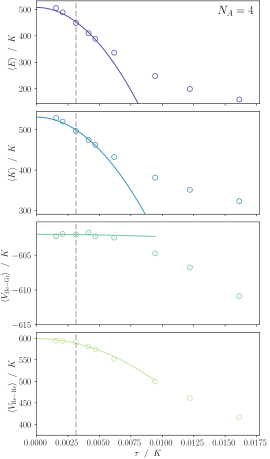

In [10]:
N = num_sites[0]

est_labels = ['E','K','V_ext','V_int']
est_ylabels = ['Energy per Particle (K)', 'Kinetic per Particle(K)', 'External Potential (K)', 'Interaction Potential (K)']
est_ylabels = [r'$\langle E \rangle \;\; / \;\; K$', r'$\langle K \rangle \;\; / \;\; K$', 
               r'$\langle V_{\rm He-Gr} \rangle \;\; / \;\; K$', r'$\langle V_{\rm He-He}\rangle \;\; / \;\; K$']

guess = [1,1,1,1]
fig, axes = plt.subplots(4,1,sharex=True, sharey=False, squeeze=True,figsize=(4,8))
fig.subplots_adjust(wspace=0.35, hspace=0.075)
params = {'mfc':'None', 'elinewidth':0.5, 'marker':'o', 'ms':5, 'lw':0.75, 'ls':'None','mew':0.75}

τ_fit = np.linspace(.00,est['t'][6],1000)
for i,ax in enumerate(axes.flatten()):
    elab = est_labels[i]
    Δelab = f'Δ{elab}'

    p0 = (1,1)
    popt,pcov = curve_fit(polyfunc,est['t'][:5],est[elab][:5]/N,sigma=est[Δelab][:5]/N,p0=p0)
    ax.plot(τ_fit,4*polyfunc(τ_fit,*popt), color=colors[i], lw=1, zorder=-10,
            label=r'$E = E_0 + c_1\mathrm{e}^{-c_2\beta}$')
    ax.errorbar(est['t'],est[elab],yerr=est[Δelab],**params, 
                color=colors[i], label='QMC')
    ax.set_ylabel(est_ylabels[i])
    if i > 2:
        ax.set_xlabel(r'$\tau\;\; / \;\; K$')
    ax.set_xlim(.0,1.1*est['t'][-2])
    ax.set_ylim(bottom=0.9*est[elab][-2])
    ax.axvline(x=0.00313,color='gray', ls='--', zorder=-10, alpha=0.5)
    
axes[2].set_ylim(bottom=-615)

axes[0].annotate(f'$N_A = {N}$', xy=(0.98,0.85),xytext=(0.98,0.85), 
                            xycoords='axes fraction', ha='right', va='bottom', fontsize=12)

## $\tau$ scaling for the potential energy

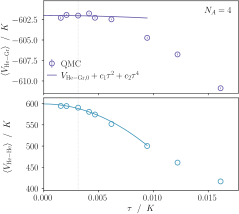

In [11]:
N = num_sites[0]

est_labels = ['V_ext','V_int']
est_ylabels = [r'$\langle V_{\rm He-Gr} \rangle \;\; / \;\; K$', r'$\langle V_{\rm He-He}\rangle \;\; / \;\; K$']

τ_fits = defaultdict(list)

guess = [1,1]
fig, axes = plt.subplots(2,1,sharex=True, sharey=False, squeeze=True,figsize=(1.025*figsize[0],1.025*figsize[0]))
fig.subplots_adjust(wspace=0.35, hspace=0.05)
params = {'mfc':'None', 'elinewidth':0.5, 'marker':'o', 'ms':5, 'lw':0.75, 'ls':'None','mew':0.75}

τ_fit = np.linspace(.00,est['t'][6],1000)
for i,ax in enumerate(axes.flatten()):
    elab = est_labels[i]
    Δelab = f'Δ{elab}'
    p0 = (1,1)
    popt,pcov = curve_fit(polyfunc,est['t'][:5],est[elab][:5]/N,sigma=est[Δelab][:5]/N,p0=p0)
    ax.plot(τ_fit,4*polyfunc(τ_fit,*popt), color=colors[i], lw=0.75, zorder=-10,
            label=r'$V_{\rm He-Gr,0} + c_1\tau^2 + c_2 \tau^4$')
    ax.errorbar(est['t'],est[elab],yerr=est[Δelab],**params, 
                color=colors[i], label='QMC')
    
    τ_fits[elab].append(τ_fit)
    τ_fits[elab].append(4*polyfunc(τ_fit,*popt))
            
    ax.set_xlim(.0,1.1*est['t'][-2])
    if est[elab][-2] > 0:
        ax.set_ylim(bottom=0.95*est[elab][-2])
    else:
        ax.set_ylim(bottom=1.001*est[elab][-2])
    ax.axvline(x=0.00313,color='gray', ls=':', zorder=-10, alpha=0.5,lw=0.5)

    
axes[0].set_ylabel(est_ylabels[0])
axes[1].set_ylabel(est_ylabels[1],labelpad=14)
axes[1].set_xlabel(r'$\tau\;\; / \;\; K$')

axes[0].annotate(f'$N_A = {N}$', xy=(0.98,0.85),xytext=(0.98,0.85), 
                            xycoords='axes fraction', ha='right', va='bottom')
#axes[1].set_ylim(493,497.9)
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[::-1], labels[::-1],loc=(0.0,0.1), handlelength=1)

### Pickle $\tau$ scaling data
This data is loaded in [beta_scaling_PIGS.ipynb](./beta_scaling_PIGS.ipynb)


In [12]:
with open('../data/tau_scaling.pickle','wb') as handle:
    pickle.dump([τ_fits,est], handle, protocol=pickle.HIGHEST_PROTOCOL)